In [1]:
import torch
import numpy as np
from torch.nn import functional as F
import time

def get_yt_map_idx_grid(img_size, scale_factor):
    yt_img_size= img_size//scale_factor
    yt_idx_grid= torch.arange(yt_img_size**2).reshape(yt_img_size, yt_img_size)
    yt_map_idx_grid_flatten= torch.tile(yt_idx_grid, (scale_factor,scale_factor,1,1)).permute(2, 0, 3, 1).reshape(img_size, img_size).flatten()

    return yt_map_idx_grid_flatten

def convert_Ht2A(Ht, lambda_scale_factor):
    """
    Convert Ht to sparse matrix A/ forward model matrix including downsampling

    Ht.shape: [1, T, img_size, img_size]
    X.shape: [n_imgs, 1, img_size, img_size]
    """
    img_size= Ht.shape[2]
    T= Ht.shape[1]
    scale_factor= 2**(lambda_scale_factor-1)
    yt_img_size= img_size//scale_factor

    Ht_flatten= Ht.reshape(-1) #shape: (T*img_size*img_size, )
    A= torch.zeros(T, yt_img_size**2, img_size**2).float() #shape: (T, yt_img_size**2, img_size**2)  ## CAUTION: MEMORY HUNGRY- 1 !!!

    yt_map_idx_grid_flatten= get_yt_map_idx_grid(img_size, scale_factor) #shape: (img_size, img_size)

    depth= torch.tile(torch.arange(T).reshape(1, -1), (img_size*img_size, 1)).T.reshape(-1)
    column= torch.tile(torch.arange(img_size*img_size), (T,)) 
    row= torch.tile(yt_map_idx_grid_flatten[np.arange(img_size*img_size)], (T,))
    
    A= A.index_put(indices=[depth, row, column], values=Ht_flatten.float()).unsqueeze(dim=0) ## CAUTION: MEMORY HUNGRY- 3 !!!
    return A

In [2]:
img_size= 4
lambda_scale_factor= 2
T=4

scale_factor= 2**(lambda_scale_factor-1)
yt_img_size= img_size//scale_factor

print(f'MatrixA shape: {(1, T, yt_img_size**2, img_size**2)}')
print(f'tot. memory requirement for MatrixA : {(T*yt_img_size**2*img_size**2)*4*1e-9} GB !!! ')


Ht= torch.randint(0, 10, (1, T, img_size, img_size))
A= convert_Ht2A(Ht, lambda_scale_factor)
X= torch.randint(0, 150, (32, 1, img_size, img_size)).float()
#X= torch.randn(32, 1, img_size, img_size)

MatrixA shape: (1, 4, 4, 16)
tot. memory requirement for MatrixA : 1.024e-06 GB !!! 


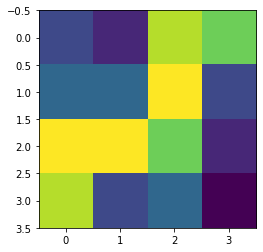

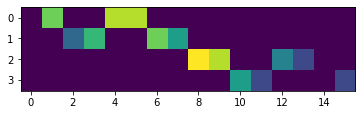

In [3]:
import matplotlib.pyplot as plt
plt.imshow(Ht[0,0])
plt.show()
plt.imshow(A[0, 1])
plt.show()

In [4]:
upscale_method1= (F.avg_pool2d((Ht*X), (scale_factor, scale_factor))*(scale_factor**2))
upscale_method2 = (A @ X.float().flatten(start_dim= 2).unsqueeze(dim=3)).reshape(-1, T, yt_img_size, yt_img_size)

print(f'is identical : {(upscale_method1== upscale_method2).all()}')
print(f'is close (how much) : {torch.isclose(upscale_method1, upscale_method2).float().mean()}')

is identical : True
is close (how much) : 1.0


# Testing

In [5]:
from torch import nn

## 1. Upsampling initialization (only) using A.transpose()



In [6]:
yt= torch.randint(0, 150, (32, T, yt_img_size, yt_img_size)).float()
batch_size= yt.shape[0]

Ht= torch.randn(1, T, img_size, img_size)
A= convert_Ht2A(Ht, lambda_scale_factor)
A_transpose= nn.Parameter(A.permute(0,1,3,2), requires_grad= True) # Get transpose for upsampling (Approx for inverse(A))
yt_upscaled = (A_transpose @ yt.flatten(start_dim= 2).unsqueeze(dim=3)).reshape(-1, T, img_size, img_size)
print(f'initial, upscaled shapes : {yt.shape} | {yt_upscaled.shape}')

yt_upscaled.sum().backward()

initial, upscaled shapes : torch.Size([32, 4, 2, 2]) | torch.Size([32, 4, 4, 4])


## 2. Learning Ht through Upsampling using A.transpose()

In [7]:
yt= torch.randint(0, 150, (32, T, yt_img_size, yt_img_size)).float()
batch_size= yt.shape[0]

Ht= nn.Parameter(torch.randn(1, T, img_size, img_size), requires_grad= True)
A= convert_Ht2A(Ht, lambda_scale_factor)
A_transpose= A.permute(0,1,3,2) # Get transpose for upsampling (Approx for inverse(A))
yt_upscaled = (A_transpose @ yt.flatten(start_dim= 2).unsqueeze(dim=3)).reshape(-1, T, img_size, img_size)
print(f'initial, upscaled shapes : {yt.shape} | {yt_upscaled.shape}')

yt_upscaled.sum().backward()

initial, upscaled shapes : torch.Size([32, 4, 2, 2]) | torch.Size([32, 4, 4, 4])


In [8]:
(A_transpose @ yt.flatten(start_dim= 2).unsqueeze(dim=3)).shape

torch.Size([32, 4, 16, 1])

In [9]:
A.shape

torch.Size([1, 4, 4, 16])

# Correction

1. Previous:

    1. A.shape: (1, T, yt_img_size^2, img_size^2)
    2. Transpose(A).shape: (1, T, img_size^2, yt_img_size^2) -> Transpose of last 2 dims of A, So will be done separately for each channel/ T
    3. yt.shape: (batch_size, T, yt_img_size^2, 1)
    4. X_recon.shape (or yt_rescaled.shape): (batch_size, T, img_size^2, 1)


2. New:
    1. A.shape: (1, **T*yt_img_size^2**, img_size^2) -> no separate dimension for T !!! (Can obtain this A matrix by concatenating dim= 1, 2 of previous A)
    2. Transpose(A).shape: (1, img_size^2, **T*yt_img_size^2**) -> Transpose the whole 2D matrix which includes different Ts as well.
    3. yt.shape: (batch_size, **T*yt_img_size^2**, 1) -> No separate dimension for T !!!
    4. X_recon.shape (or yt_rescaled.shape): **(batch_size, img_size^2, 1)** -> No dimension for T. All the channels have mixed up !!!



MatrixA shape: (1, 4, 4, 16)
tot. memory requirement for MatrixA : 1.024e-06 GB !!! 


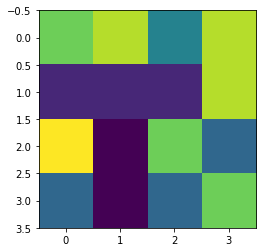

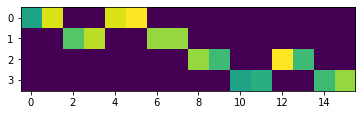

In [10]:
from torch import nn
import torch

img_size= 4
lambda_scale_factor= 2
T=4

scale_factor= 2**(lambda_scale_factor-1)
yt_img_size= img_size//scale_factor

print(f'MatrixA shape: {(1, T, yt_img_size**2, img_size**2)}')
print(f'tot. memory requirement for MatrixA : {(T*yt_img_size**2*img_size**2)*4*1e-9} GB !!! ')


Ht= torch.randint(10, 20, (1, T, img_size, img_size))
A= convert_Ht2A(Ht, lambda_scale_factor)
X= torch.randint(0, 150, (32, 1, img_size, img_size)).float()
#X= torch.randn(32, 1, img_size, img_size)

yt= torch.randint(0, 150, (32, T, yt_img_size, yt_img_size)).float()
batch_size= yt.shape[0]


import matplotlib.pyplot as plt
plt.imshow(Ht[0,0])
plt.show()
plt.imshow(A[0, 1])
plt.show()

tensor(True)
tensor(True)
tensor(True)
tensor(True)


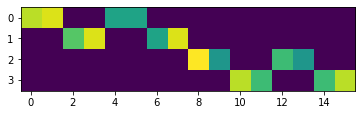

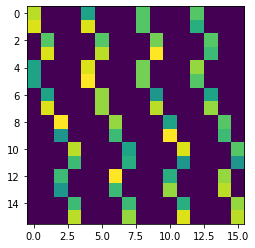

In [11]:
A_transpose_special= A.reshape(1, T*yt_img_size**2, img_size**2).permute(0, 2, 1)
for i in range(T):
    print((A[0, i]== A_transpose_special[0].T[i*T:(i+1)*T]).all())
    
plt.imshow(A[0,0])
plt.show()
plt.imshow(A_transpose_special[0])

In [13]:
#Ht= torch.randn(1, T, img_size, img_size)
A= convert_Ht2A(Ht, lambda_scale_factor)
A_transpose_special= A.reshape(1, T*yt_img_size**2, img_size**2).permute(0, 2, 1)
yt_upscaled = (A_transpose_special @ yt.flatten(start_dim= 1).unsqueeze(dim=2)).reshape(batch_size, 1, img_size, img_size)
print(f'initial, upscaled shapes : {yt.shape} | {yt_upscaled.shape}')

#yt_upscaled.sum().backward()

initial, upscaled shapes : torch.Size([32, 4, 2, 2]) | torch.Size([32, 1, 4, 4])


### Compare using Previous

In [15]:
img_size= 32
lambda_scale_factor= 3
T=8

scale_factor= 2**(lambda_scale_factor-1)
yt_img_size= img_size//scale_factor

print(f'MatrixA shape: {(1, T, yt_img_size**2, img_size**2)}')
print(f'tot. memory requirement for MatrixA : {(T*yt_img_size**2*img_size**2)*4*1e-9} GB !!! ')


Ht= torch.randint(10, 20, (1, T, img_size, img_size))
A= convert_Ht2A(Ht, lambda_scale_factor)
X= torch.randint(0, 150, (32, 1, img_size, img_size)).float()

yt= torch.randint(0, 150, (32, T, yt_img_size, yt_img_size)).float()
batch_size= yt.shape[0]

MatrixA shape: (1, 8, 64, 1024)
tot. memory requirement for MatrixA : 0.002097152 GB !!! 


In [16]:
A_transpose_previous= A.permute(0,1,3,2) # Get transpose for upsampling (Approx for inverse(A))
A_transpose_special= A.reshape(1, T*yt_img_size**2, img_size**2).permute(0, 2, 1)

yt_upscaled_previous = (A_transpose_previous @ yt.flatten(start_dim= 2).unsqueeze(dim=3)).reshape(-1, T, img_size, img_size)

for i in range(T):
    yt_zeros= torch.zeros(32, T * yt_img_size*yt_img_size).float()
    yt_zeros[:, i*yt_img_size*yt_img_size: (i+1)*yt_img_size*yt_img_size]= yt[:, i].flatten(start_dim= 1)
    print(f'Created `yt` which have non-zero values only in the region which multiply with T={i} section in transposed-A ')
    #yt_zeros= yt.flatten(start_dim= 1)
    
    yt_rearranged= yt_zeros.flatten(start_dim= 1).unsqueeze(dim=2)
    yt_upscaled_new = (A_transpose_special @ yt_rearranged).reshape(batch_size, 1, img_size, img_size)
    print('is True : new_upscaled yt vs. previous_upscaled_yt[T=i] : ', (yt_upscaled_new[:,0]==yt_upscaled_previous[:, i]).all(), '\n')

Created `yt` which have non-zero values only in the region which multiply with T=0 section in transposed-A 
is True : new_upscaled yt vs. previous_upscaled_yt[T=i] :  tensor(True) 

Created `yt` which have non-zero values only in the region which multiply with T=1 section in transposed-A 
is True : new_upscaled yt vs. previous_upscaled_yt[T=i] :  tensor(True) 

Created `yt` which have non-zero values only in the region which multiply with T=2 section in transposed-A 
is True : new_upscaled yt vs. previous_upscaled_yt[T=i] :  tensor(True) 

Created `yt` which have non-zero values only in the region which multiply with T=3 section in transposed-A 
is True : new_upscaled yt vs. previous_upscaled_yt[T=i] :  tensor(True) 

Created `yt` which have non-zero values only in the region which multiply with T=4 section in transposed-A 
is True : new_upscaled yt vs. previous_upscaled_yt[T=i] :  tensor(True) 

Created `yt` which have non-zero values only in the region which multiply with T=5 section

## Multiple channels: for implementation

In [70]:
from torch import nn
import torch

img_size= 16
lambda_scale_factor= 2
T=3

scale_factor= 2**(lambda_scale_factor-1)
yt_img_size= img_size//scale_factor

print(f'MatrixA shape: {(1, T, yt_img_size**2, img_size**2)}')
print(f'tot. memory requirement for MatrixA : {(T*yt_img_size**2*img_size**2)*4*1e-9} GB !!! ')

Ht= torch.randint(10, 20, (1, T, img_size, img_size))
X= torch.randint(0, 150, (32, 1, img_size, img_size)).float()
yt= torch.randint(0, 150, (32, T, yt_img_size, yt_img_size)).float()
batch_size= yt.shape[0]

A= convert_Ht2A(Ht, lambda_scale_factor) # shape: (1, T, yt_img_size^2, img_size^2)
A_transpose_special= A.reshape(1, T*yt_img_size**2, img_size**2).permute(0, 2, 1) # shape: (1, img_size^2, T*yt_img_size^2)
A_transpose_special_tiled = torch.tile(A_transpose_special.unsqueeze(dim=1), (1, T, 1, 1))# shape: (1, T, img_size^2, T*yt_img_size^2)
yt_flatten = yt.flatten(start_dim= 1).unsqueeze(2).unsqueeze(1) # shape: (n_samples, 1, T*yt_img_size^2, 1)
yt_upscaled  =(A_transpose_special_tiled @ yt_flatten).reshape(batch_size, T, img_size, img_size) # shape: (n_samples, T, img_size, img_size)
 
print(f'initial, upscaled shapes : {yt.shape} | {yt_upscaled.shape}')


MatrixA shape: (1, 3, 64, 256)
tot. memory requirement for MatrixA : 0.00019660800000000003 GB !!! 
initial, upscaled shapes : torch.Size([32, 3, 8, 8]) | torch.Size([32, 3, 16, 16])


In [71]:
print('same yt should be returned for each T/ channel')
for idx in range(1, T):
    print(f'Compare channel {0} with {idx} : ',(yt_upscaled[:,0]==yt_upscaled[:,idx]).all())

same yt should be returned for each T/ channel
Compare channel 0 with 1 :  tensor(True)
Compare channel 0 with 2 :  tensor(True)
